# 📚  Exercise Session - Week 6

Welcome to Week 6 exercise's session of CS552-Modern NLP!


> **What will be covered:**

[Part 1: Biases](#bias0)
- [1.1 Hypothesis only NLI](#bias1)

[Part 2: Prompting](#prompt0)
- [2.1 Zero-shot](#promp1)
- [2.2 Few-shot](#promt2)


> **By the end of the session you will be able to:**
> - Gain an understanding of dataset biases
> - Reformulate a NLP problem as a MLM with prompts
> - Evaluate the benefit of using prompts


<a name="bias0"></a>
## 1. Biases

This first part of the lab will be inspired by [Hypothesis Only Baselines in Natural Language Inference](https://aclanthology.org/S18-2023.pdf), where we will test a classifier's ability to perform the NLI task with only the hypothesis. 

Remember, in NLI the model needs to judge whether, given a premise, if a hypothesis is necesarily true (entailment), false (condradiction), or neither (neutral). The label of the hypothesis is entirely based upon what the initial premise is, and idealy the model would take into account both premise and hypothesis to perform the task. If the model is able to correctly guess the label without seeing the premise, than it is likely detecting statisitcal patterns that are undesirable, such as tendency to use certain words among different classes (ex: using negation words such as 'not' for the contradiction label).


In this dataset the labels are as follows: 0-Entailment, 1- Neutral, and 2- Contradict.

In [ ]:
!pip install transformers
!pip install jsonpickle
!pip install datasets


In [1]:
import json
import jsonpickle
import os
from typing import List, Dict, Optional
import datasets
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import RandomSampler, DataLoader, SequentialSampler
from tqdm import trange, tqdm
from transformers import RobertaForMaskedLM,RobertaTokenizer, RobertaForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import sys
import matplotlib.pyplot as plt


ModuleNotFoundError: ignored

<a name="bias1"></a>
## 1.1 Hypothesis only NLI

We have provided a model trained only on hypotheses from the SNLI dataset. Lets see how well it performs.

In [ ]:
from datasets import load_dataset
test_dataset = load_dataset("snli", split='test[:5%]')
model = DistilBertForSequenceClassification.from_pretrained('nli_hyp_distil')
tokenizer = DistilBertTokenizer.from_pretrained('nli_hyp_distil')
test_dataset = test_dataset.filter(lambda example: example["label"]!=-1)


In [ ]:
def get_guess(test_data):
  inputs = tokenizer(test_data['hypothesis'], return_tensors="pt", truncation=True)
  with torch.no_grad():
    return model(**inputs).logits.argmax().item()

In [ ]:
test_dataset = pd.DataFrame(test_dataset)
guess = test_dataset.apply(lambda x: get_guess(x), axis=1).tolist()
test_dataset['guess'] = guess

Qualitatively look at groud truth label distribution, as well as if label assignment approximates the truth

In [ ]:
bins = np.linspace(-0.25, 2.25, 6)
plt.hist([test_dataset['guess'], test_dataset['label']], bins, label=['guess', 'truth'])
plt.legend()
plt.show()

View accuracy and f1

In [ ]:
print("Accuracy :", accuracy_score(test_dataset['label'], test_dataset['guess']))
print("Contradiction Accuracy :", accuracy_score(test_dataset[test_dataset['label']==2]['label'], test_dataset[test_dataset['label']==2]['guess']))
print("Neutral Accuracy :", accuracy_score(test_dataset[test_dataset['label']==1]['label'], test_dataset[test_dataset['label']==1]['guess']))
print("Entailment Accuracy :", accuracy_score(test_dataset[test_dataset['label']==0]['label'], test_dataset[test_dataset['label']==0]['guess']))

print("F1 :", f1_score(test_dataset['label'], test_dataset['guess'], average = 'micro'))


Accuracy : 0.6808080808080809
Contradiction Accuracy : 0.6770186335403726
Neutral Accuracy : 0.6583850931677019
Entailment Accuracy : 0.7052023121387283
F1 : 0.6808080808080809


As you see, the model is able to correctly guess the labels of almost 70% of the NLI hypotheses without seeing what the premise is.

Question: What do you think are ways that biases can be mitigated? Think about both the data collection process and model training for places where one can intervene.

<a name="prompt0"></a>
## 2. Prompting

The following sections will he based off the papers [Exploiting Cloze Questions for Few Shot Text Classification and Natural
Language Inference](https://arxiv.org/pdf/2001.07676.pdf) and [How Many Data Points is a Prompt Worth?](https://arxiv.org/pdf/2103.08493.pdf).

The first paper introduced Pattern Exploiting Training (PET), in which a NLP task is reformulated to a cloze style task for few shot learning. We will go into this a little more during the few-shot section of this lab. What you need to know for now, is that instead of training a model with a classification head, these models have a LM head to perform a classification task. Unlike language modeling, instead of predicting a word from the whole vocaulary, we are predicting a word from a list of verbalizers, where a word in the vocab is mapped to each label.


We will be looking at classification tasks (NLI and sentiment) as they need only using one mask/single word verbalizers, however this paradigm can be extended to other tasks, with multiword verbalizers.

First lets try zero shots. All models from now on will be built off Roberta large.


In [ ]:
from datasets import load_dataset
test_dataset = load_dataset('imdb', split='test')
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
model = RobertaForMaskedLM.from_pretrained('roberta-large')

test_dataset = test_dataset.shuffle(907)

In [ ]:
def get_targets(verbalizer = 1):  #retreives the token ids for the verbalizers
  targets = verbalize(verbalizer).keys()
  target_ids = []
  for target in targets:
    id= tokenizer.get_vocab().get("\u0120"+ target, None) #how roberta ecodes wods
    target_ids.append(id)
  return target_ids
  
def lm_guess_sent(text, template_num = 1, verb_num = 1):
  target_ids = get_targets(verb_num) #get ids
  verbalizer = verbalize(verb_num) #return verbalizer
  text_template = template(text, template_num) #return template with text
  encoded_input = tokenizer(text_template, return_tensors='pt', truncation=True)
  masked_index = torch.nonzero(tokenizer(text_template, return_tensors='pt', truncation=True)["input_ids"][0] == tokenizer.mask_token_id, as_tuple=False).squeeze(-1) #getting index of mask token
  model_outputs = model(**encoded_input)
  outputs = model_outputs["logits"]
  logits = outputs[0, masked_index, :]
  probs = logits.softmax(dim=-1) #probability of tokens
  probs = probs[..., target_ids] #probability for the verbalizers
  values, predictions = probs.topk(1) #gets the prediction index
  input_ids = encoded_input["input_ids"][0]
  tokens = input_ids.numpy().copy()
  p = target_ids[predictions]
  prediction = verbalizer[tokenizer.decode([p]).strip()] #get corresponging label from verbalizer
  return prediction

def lm_guess_nli(text_a, text_b, template_num = 1, verb_num = 1):
  target_ids = get_targets(verb_num) #get ids
  verbalizer = verbalize(verb_num) #return verbalizer
  text_template = template(text_a, text_b, template_num) #return template with text
  encoded_input = tokenizer(text_template, return_tensors='pt', truncation=True)
  masked_index = torch.nonzero(tokenizer(text_template, return_tensors='pt', truncation=True)["input_ids"][0] == tokenizer.mask_token_id, as_tuple=False).squeeze(-1) #getting index of mask token
  model_outputs = model(**encoded_input)
  outputs = model_outputs["logits"]
  logits = outputs[0, masked_index, :]
  probs = logits.softmax(dim=-1) #probability of tokens
  probs = probs[..., target_ids] #probability for the verbalizers
  values, predictions = probs.topk(1) #gets the prediction index
  input_ids = encoded_input["input_ids"][0]
  tokens = input_ids.numpy().copy()
  p = target_ids[predictions]
  prediction = verbalizer[tokenizer.decode([p]).strip()] #get corresponging label from verbalizer
  return prediction


<a name="prompt1"></a>
### 2.1 Zero shot


We will be using the IMDB dataset again to test prompting in the zero shot setting.

We need two things to do the prompting

- a verbalizer that matches a word to each label
- a template to add the review, with one masked token that will predict one of the verbalizers

Success of this method varies by template and verbalizer, so it is nice to test a few.

In [ ]:
def verbalize(num = 1):
  if num == 1:
    return {"great":1, "horrible":0}
  if num == 2:
    return {"great":1, "terrible":0}


def template(text, num = 1):
    if num == 1:
      return "It was <mask>." + text
    if num == 2:
      return "So <mask>!" + text


Alright, lets see how the pre-trained roberta does on the prompted sentiment analysis.

#### Verbalizer number 1

In [ ]:
test_data_subset = pd.DataFrame(test_dataset[0:500])

guess = test_data_subset.apply(lambda x: lm_guess_sent(x['text'], template_num = 1, verb_num = 1), axis=1).tolist()


In [ ]:
test_data_subset['guess'] = guess

print("Accuracy :", accuracy_score(test_data_subset['label'], test_data_subset['guess']))
print("Positive Accuracy :", accuracy_score(test_data_subset[test_data_subset['label']==1]['label'], test_data_subset[test_data_subset['label']==1]['guess']))
print("Negative Accuracy :", accuracy_score(test_data_subset[test_data_subset['label']==0]['label'], test_data_subset[test_data_subset['label']==0]['guess']))

print("F1 :", f1_score(test_data_subset['label'], test_data_subset['guess'], average = 'micro'))


Hmm, seems to be a tendency to fill in "great" for most reviews.

#### Verbalizer number 2
Lets try different verbalizers (selection 2).






In [ ]:
#guess = [lm_guess_sent(test_dataset['text'][i], template_num = 1, verb_num = 2)[1] for i in range(150)]
guess = test_data_subset.apply(lambda x: lm_guess_sent(x['text'], template_num = 1, verb_num = 2), axis=1).tolist()


In [ ]:
test_data_subset['guess2'] = guess

print("Accuracy :", accuracy_score(test_data_subset['label'], test_data_subset['guess2']))
print("Positive Accuracy :", accuracy_score(test_data_subset[test_data_subset['label']==1]['label'], test_data_subset[test_data_subset['label']==1]['guess2']))
print("Negative Accuracy :", accuracy_score(test_data_subset[test_data_subset['label']==0]['label'], test_data_subset[test_data_subset['label']==0]['guess2']))

print("F1 :", f1_score(test_data_subset['label'], test_data_subset['guess2'], average = 'micro'))


Accuracy : 0.82
Positive Accuracy : 0.9642857142857143
Negative Accuracy : 0.6363636363636364
F1 : 0.82


Question: How well do you think this model performed, given it has not been trained on a classification task before? Why do you think this formulation of the task works in the zero-shot setting? Can you think of any ways to pick the most effective verbalizers in a more systematic way?

You can feel free to edit the templates/verbalizers to see how these choices effect performance, and if you can improve performance.

<a name="prompt2"></a>
### 2.2 Few shot

Now we will test a model that has been trained on a small number of samples (20 total) using Pattern Exploiting Training (PET) for NLI.

In the origal paper, authors propose creating an ensemble of models with different verbalizers, using this ensemble to create a soft-labeled dataset, which can then be used to to train a classifier for the task. This schematic is shown below (ignore the iPET sections)

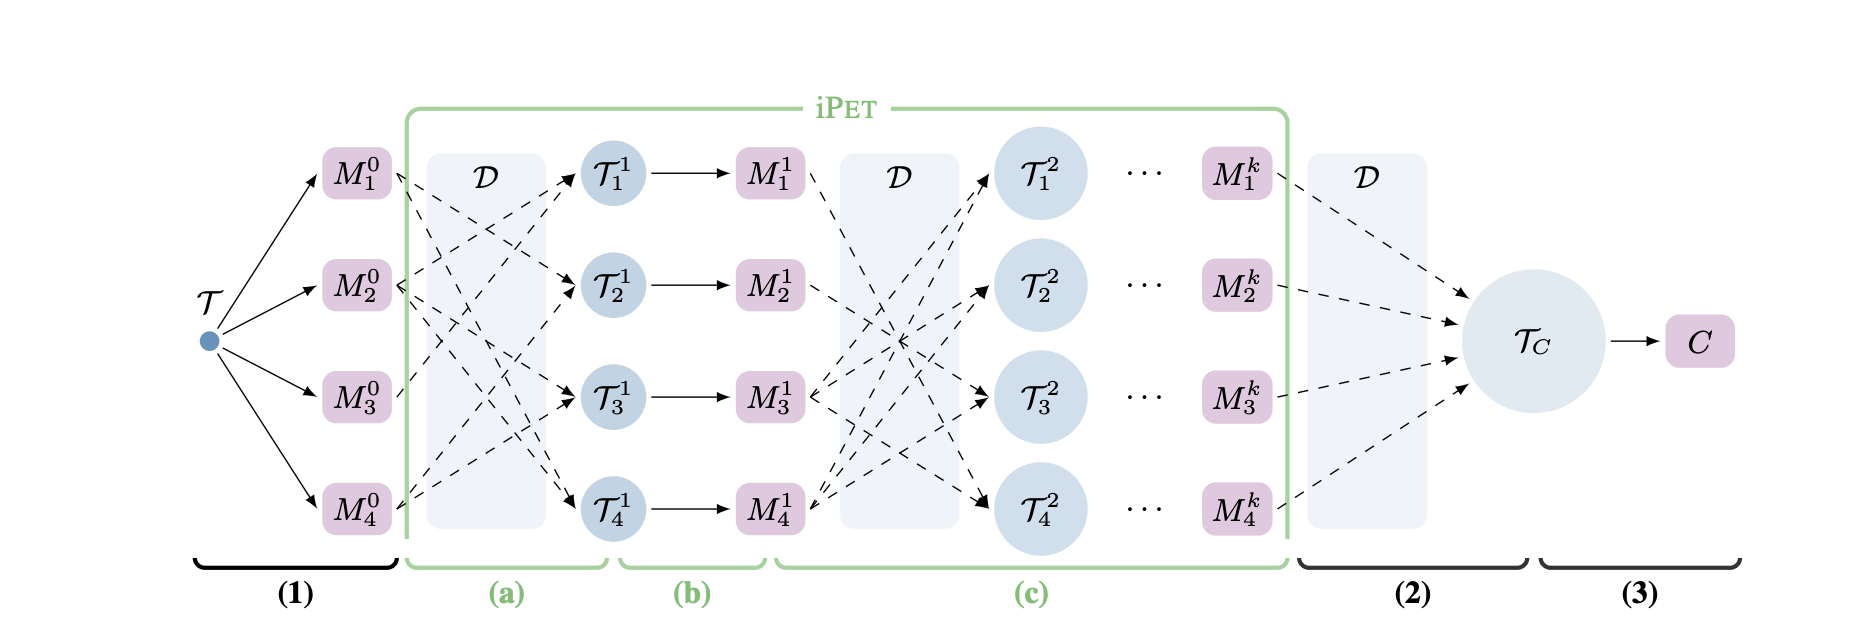


The model we will be using did not go through this whole processs. We are testing a model that has been trained on one pattern-verbalizer pair (one of the Ms in the graph).

In [ ]:
def template(text_a, text_b, num = 1):
    if num == 1:
      return text_a + "? <mask>, "+ text_b


def verbalize(num = 1):
  if num == 1:
    return {"Wrong": 2, "Right": 0, "Maybe": 1}
  if num == 2:
    return {"No": 2, "Yes": 0, "Maybe": 1}


Lets test how the model performs in the NLI task.

#### Verbalizer number 1

We will now test the accuracy using the verbalizer/template pair the model was trained on.

In [ ]:
test_dataset = pd.DataFrame(load_dataset("glue", "mnli", split='validation_matched[:2%]'))
tokenizer = RobertaTokenizer.from_pretrained('20shots-nli')
model = RobertaForMaskedLM.from_pretrained('20shots-nli')
guess = test_dataset.apply(lambda x: lm_guess_nli(x['premise'],x['hypothesis'], template_num = 1, verb_num = 1), axis=1).tolist()
test_dataset = pd.DataFrame(test_dataset)
test_dataset['guess'] = guess

print("Accuracy :", accuracy_score(test_dataset['label'], test_dataset['guess']))
print("Contradiction Accuracy :", accuracy_score(test_dataset[test_dataset['label']==2]['label'], test_dataset[test_dataset['label']==2]['guess']))
print("Neutral Accuracy :", accuracy_score(test_dataset[test_dataset['label']==1]['label'], test_dataset[test_dataset['label']==1]['guess']))
print("Entailment Accuracy :", accuracy_score(test_dataset[test_dataset['label']==0]['label'], test_dataset[test_dataset['label']==0]['guess']))

print("F1 :", f1_score(test_dataset['label'], test_dataset['guess'], average = 'micro'))


In [ ]:
bins = np.linspace(-0.25, 2.25, 6)
plt.hist([test_dataset['guess'], test_dataset['label']], bins, label=['guess', 'truth'])
plt.show()

Question: How do you think the model did, given it was trained with 20 examples across three classes.

#### Verbalizer number 2

Now we will use different verbalizers to see how the model performs.

In [ ]:

# test_dataset = pd.DataFrame(test_dataset)
guess = test_dataset.apply(lambda x: lm_guess_nli(x['premise'],x['hypothesis'], template_num = 1, verb_num = 2), axis=1).tolist()
test_dataset = pd.DataFrame(test_dataset)
test_dataset['guess'] = guess

print("Accuracy :", accuracy_score(test_dataset['label'], test_dataset['guess']))
print("Contradiction Accuracy :", accuracy_score(test_dataset[test_dataset['label']==2]['label'], test_dataset[test_dataset['label']==2]['guess']))
print("Neutral Accuracy :", accuracy_score(test_dataset[test_dataset['label']==1]['label'], test_dataset[test_dataset['label']==1]['guess']))
print("Entailment Accuracy :", accuracy_score(test_dataset[test_dataset['label']==0]['label'], test_dataset[test_dataset['label']==0]['guess']))

print("F1 :", f1_score(test_dataset['label'], test_dataset['guess'], average = 'micro'))


In [ ]:
bins = np.linspace(-0.25, 2.25, 6)
plt.hist([test_dataset['guess'], test_dataset['label']], bins, label=['guess', 'truth'])
plt.show()

### Prompting vs Fine-tuning
Now lets compare it to the typical clasification fine-tuning. The model we will use now was finetuned with 200 samples, so 10 times as much data as the prompting model.

In [ ]:
# from datasets import load_dataset
test_dataset = load_dataset("glue", "mnli", split='validation_matched[:2%]')
tokenizer = RobertaTokenizer.from_pretrained('200_shot_nli')
model = RobertaForSequenceClassification.from_pretrained('200_shot_nli')

In [ ]:
guess = []
for i in range(len(test_dataset)):
    inputs = tokenizer(test_dataset['premise'][i],test_dataset['hypothesis'][i], return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    guess.append(logits.argmax().item())


In [ ]:
test_dataset = pd.DataFrame(test_dataset)
test_dataset['guess'] = guess
print("Accuracy :", accuracy_score(test_dataset['label'], test_dataset['guess']))
print("Contradiction Accuracy :", accuracy_score(test_dataset[test_dataset['label']==2]['label'], test_dataset[test_dataset['label']==2]['guess']))
print("Neutral Accuracy :", accuracy_score(test_dataset[test_dataset['label']==1]['label'], test_dataset[test_dataset['label']==1]['guess']))
print("Entailment Accuracy :", accuracy_score(test_dataset[test_dataset['label']==0]['label'], test_dataset[test_dataset['label']==0]['guess']))

print("F1 :", f1_score(test_dataset['label'], test_dataset['guess'], average = 'micro'))


Questions: How did prompting with compare to classification fine tuning with 10x the data? What do you think makes for the best verbalizes?